In [32]:
path = './DATASET/hour.csv'

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [34]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError as Mae
from keras.optimizers import Adam

In [35]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi': 80})

In [36]:
# pip install tensorflow

In [37]:
# pip install keras

In [38]:
# pip install pmdarima

# Common functions

In [39]:
# For generating sequences of data
def matrix_and_vector_generator(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [40]:
# For removing outliers
def replace_outliers_quantile(data, q_low=0.05, q_high=0.95):
    q1 = data.quantile(q_low)
    q3 = data.quantile(q_high)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data_clipped = data.clip(lower_bound, upper_bound)
    num_outliers = (data < lower_bound) | (data > upper_bound).sum()
    return data_clipped, num_outliers # Returning data cleaned, number of outliers

# Loading dataset

In [41]:
data = pd.read_csv(path)
def get_data():
    return data

In [42]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [43]:
data['time'] = pd.to_datetime(data['dteday']) + pd.to_timedelta(data['hr'], unit='h')
data['time'] = data['time'].dt.strftime('%m-%d-%Y %H:%M:%S')

In [44]:
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,01-01-2011 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,01-01-2011 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,01-01-2011 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,01-01-2011 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,01-01-2011 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,12-31-2012 19:00:00
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,12-31-2012 20:00:00
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,12-31-2012 21:00:00
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,12-31-2012 22:00:00


In [45]:
categorical_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'hum', 'windspeed']
features = categorical_features + numerical_features
target = ['cnt']

In [46]:
data[numerical_features].describe()

,temp,hum,windspeed
count,17379.000000,17379.000000,17379.000000
mean,0.496987,0.627229,0.190098
std,0.192556,0.192930,0.122340
min,0.020000,0.000000,0.000000
25%,0.340000,0.480000,0.104500
50%,0.500000,0.630000,0.194000
75%,0.660000,0.780000,0.253700
max,1.000000,1.000000,0.850700


In [47]:
data.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
time          False
dtype: bool

# Splitting data into train and test

In [48]:
train, test = train_test_split(data, random_state=42, shuffle=True)

In [49]:
train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
1945,1946,2011-03-26,2,0,3,20,0,6,0,2,0.28,0.2727,0.45,0.2537,18,67,85,03-26-2011 20:00:00
13426,13427,2012-07-18,3,1,7,15,0,3,1,3,0.92,0.8485,0.35,0.3582,42,152,194,07-18-2012 15:00:00
12898,12899,2012-06-26,3,1,6,15,0,2,1,1,0.72,0.6515,0.28,0.4627,88,229,317,06-26-2012 15:00:00
2570,2571,2011-04-22,2,0,4,0,0,5,1,1,0.36,0.3485,0.62,0.1940,3,30,33,04-22-2011 00:00:00
10764,10765,2012-03-29,2,1,3,15,0,4,1,1,0.52,0.5000,0.39,0.3582,109,198,307,03-29-2012 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,11285,2012-04-20,2,1,4,9,0,5,1,1,0.46,0.4545,0.88,0.0896,30,329,359,04-20-2012 09:00:00
11964,11965,2012-05-18,2,1,5,17,0,5,1,1,0.66,0.6212,0.34,0.1343,124,688,812,05-18-2012 17:00:00
5390,5391,2011-08-17,3,0,8,12,0,3,1,1,0.80,0.7273,0.43,0.2836,26,163,189,08-17-2011 12:00:00
860,861,2011-02-08,1,0,2,7,0,2,1,1,0.24,0.1970,0.65,0.4179,3,97,100,02-08-2011 07:00:00


In [50]:
print("Min Temp value: ", data['temp'].min())
print("Max Temp value: ", data['temp'].max())

Min Temp value:  0.02
Max Temp value:  1.0


# Outlier analysis

[Text(0.5, 0, 'Temperature'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

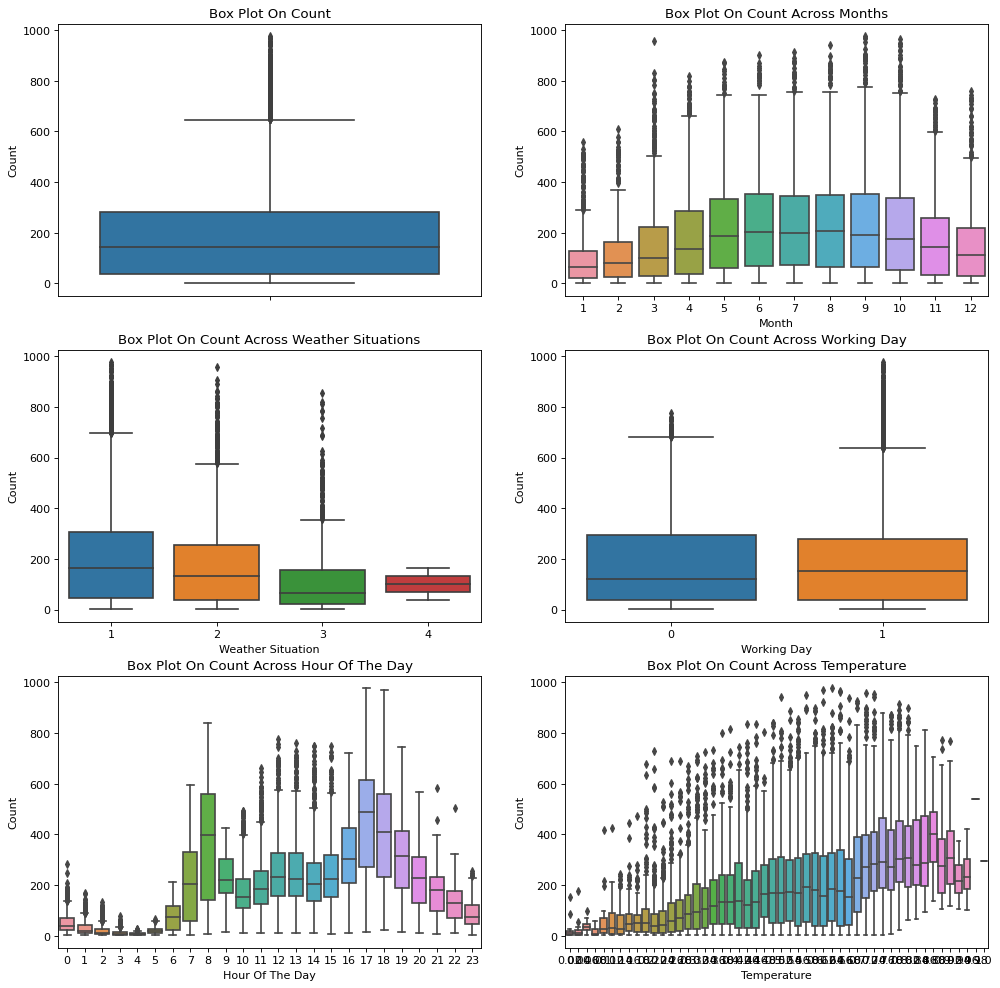

In [51]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=train,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="cnt",x="hr",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="cnt",x="temp",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")

# Removing outliers

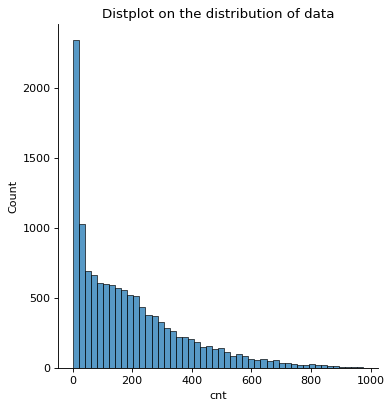

In [52]:
sns.displot(train['cnt']).set(title='Distplot on the distribution of data')

In [53]:
print("Total data: ",train.cnt.count())

Total data:  13034


In [54]:
# q1 = train.cnt.quantile(0.25)
# q3 = train.cnt.quantile(0.75)
# iqr = q3 - q1
# lower_bound = q1 -(1.5 * iqr) 
# upper_bound = q3 +(1.5 * iqr)
# outliers = train.loc[(train.cnt < lower_bound) | (train.cnt > upper_bound)]
# train = train.loc[(train.cnt >= lower_bound) & (train.cnt <= upper_bound)]

In [55]:
# outliers.cnt

In [56]:
# correct.cnt

In [57]:
# print("Total data: ",train.cnt.count())

[Text(0.5, 1.0, 'Heat map of correlation between different numerical features')]

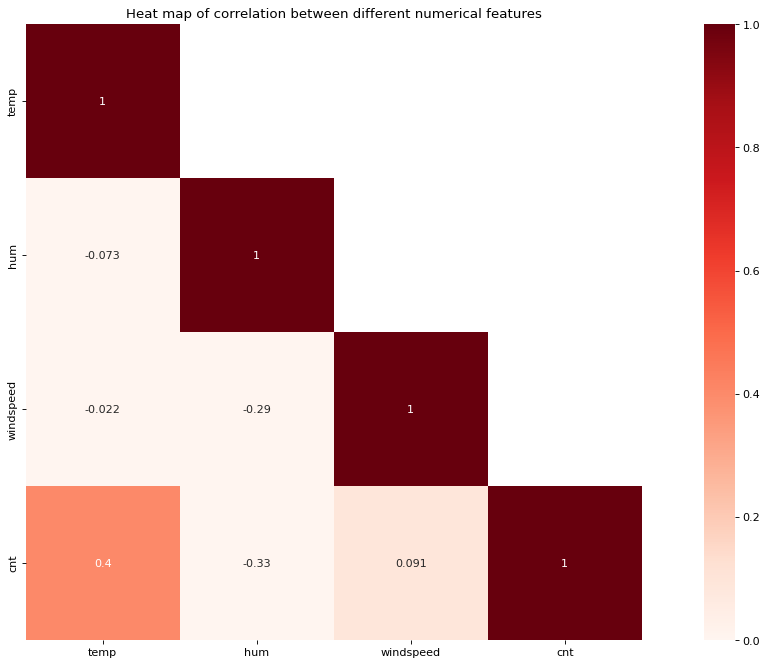

In [58]:
matrix = train[numerical_features  + target].corr()
heat = np.array(matrix)

heat[np.tril_indices_from(heat)] = False
fig, axs = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(matrix,mask=heat, vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds").set(title='Heat map of correlation between different numerical features')

[Text(0.5, 1.0, 'Heat map of correlation between different categorical features')]

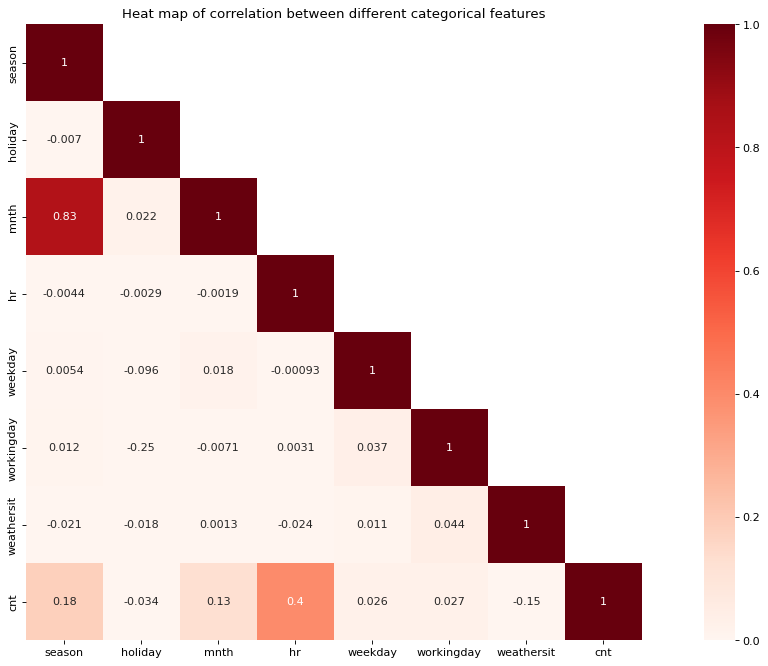

In [59]:
matrix = train[categorical_features  + target].corr()
heat = np.array(matrix)

heat[np.tril_indices_from(heat)] = False
fig, axs = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(matrix,mask=heat, vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds").set(title='Heat map of correlation between different categorical features')

In [60]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
1945,1946,2011-03-26,2,0,3,20,0,6,0,2,0.28,0.2727,0.45,0.2537,18,67,85,03-26-2011 20:00:00
13426,13427,2012-07-18,3,1,7,15,0,3,1,3,0.92,0.8485,0.35,0.3582,42,152,194,07-18-2012 15:00:00
12898,12899,2012-06-26,3,1,6,15,0,2,1,1,0.72,0.6515,0.28,0.4627,88,229,317,06-26-2012 15:00:00
2570,2571,2011-04-22,2,0,4,0,0,5,1,1,0.36,0.3485,0.62,0.1940,3,30,33,04-22-2011 00:00:00
10764,10765,2012-03-29,2,1,3,15,0,4,1,1,0.52,0.5000,0.39,0.3582,109,198,307,03-29-2012 15:00:00


In [61]:
x_train = train[features].values
y_train = train[target].values.ravel()

forest = RandomForestRegressor(n_estimators=200, random_state=1)
forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=1)

In [62]:
print("For train data: ")
pred = forest.predict(x_train)

rmse = np.sqrt(mean_squared_error(y_train, pred))
mae = mean_absolute_error(y_train, pred)

print("RMSE: ", rmse)
print("MAE: ", mae)

For train data: 
RMSE:  24.97183086656875
MAE:  16.249739377598516


In [63]:
print("For Test data: ")

x_test = test[features].values
y_test = test[target].values.ravel()

pred = forest.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("RMSE: ", rmse)
print("MAE: ", mae)

For Test data: 
RMSE:  65.72315437432128
MAE:  42.76768902131624


# ARMA Model

In [64]:
dup_df = data.copy()

split = int(len(dup_df) * 0.8)

dup_df.set_index(keys=['time'], inplace=True)

dup_df.index = pd.to_datetime(dup_df.index)

In [65]:
train_data = dup_df.iloc[:split]
test_data = dup_df.iloc[split:]

In [66]:
train_data = train_data[['cnt']]
test_data = test_data[['cnt']]

In [67]:
print("Length before resampling: ", str(len(train_data)))
new_train_data = train_data.resample('D').mean()
print("Length after resampling: ", str(len(new_train_data)))
new_test_data = test_data.resample('D').mean()

Length before resampling:  13903
Length after resampling:  585


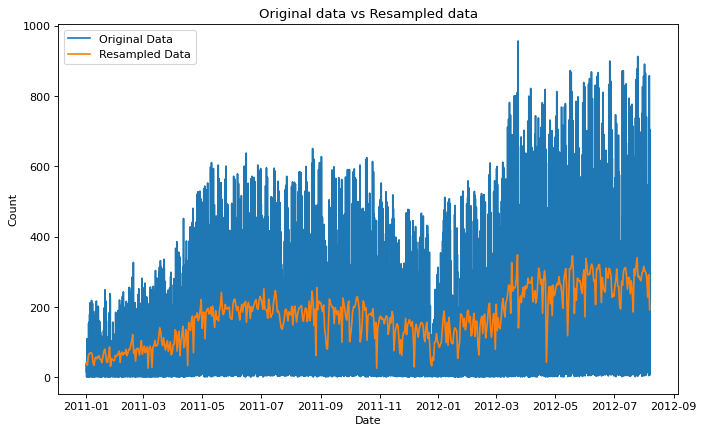

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['cnt'], label='Original Data')
plt.plot(new_train_data['cnt'], label='Resampled Data')
plt.title('Original data vs Resampled data')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

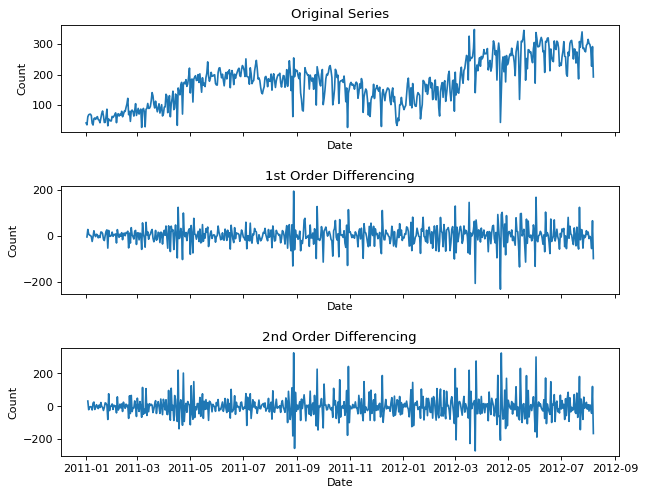

In [73]:
# Now since the graph is not stationary, turn it to stationary

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi': 80})
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

df = new_train_data
df.value = df.cnt

# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(df.value); 
axes[0].set_title('Original Series')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Count')
# plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1].plot(df.value.diff())
axes[1].set_title('1st Order Differencing')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Count')
# plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

axes[2].plot(df.value.diff().diff())
axes[2].set_title('2nd Order Differencing')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Count')

fig.subplots_adjust(hspace=0.5)
plt.show()

# On 2nd order differencing we are loosing more information so considering 1st order differencing
# d can be taken as 2

In [74]:
# To test if the differenced time series is stationary
from statsmodels.tsa.stattools import adfuller
test = new_train_data.copy()
count = 2

for i in range(count):
    test.cnt = test.cnt.diff() # Differencing 1 time
    test['cnt'].fillna(test['cnt'][1], inplace=True)

result = adfuller(test['cnt'])
result

# Since p-value < 0.05, it is stationary

(-11.097275170890004,
 3.94499824137352e-20,
 19,
 565,
 {'1%': -3.4419770063102213,
  '5%': -2.866669060591297,
  '10%': -2.5695016312945413},
 5732.150899420619)

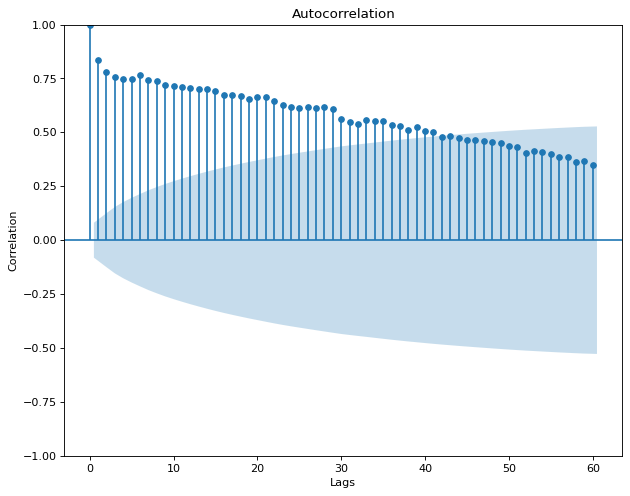

In [75]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(new_train_data['cnt'], lags = 60)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

# p value can be taken as 7

c:\Users\Akash M\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


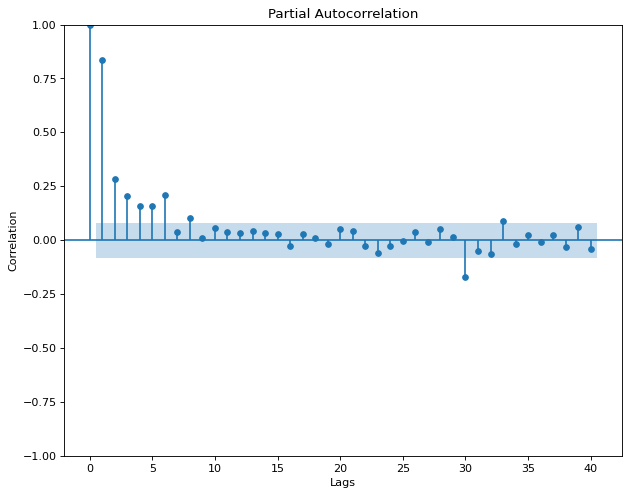

In [76]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(new_train_data['cnt'], lags = 40)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

# p value can be taken as 5

In [77]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df.value, order=(10,3,8))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Akash M\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  585
Model:                ARIMA(10, 3, 8)   Log Likelihood               -2919.412
Date:                Thu, 20 Apr 2023   AIC                           5876.824
Time:                        15:19:24   BIC                           5959.787
Sample:                    01-01-2011   HQIC                          5909.164
                         - 08-07-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.3746      0.098    -34.298      0.000      -3.567      -3.182
ar.L2         -5.3495      0.347    -15.416      0.000      -6.030      -4.669
ar.L3         -4.7736      0.626     -7.620      0.0

c:\Users\Akash M\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


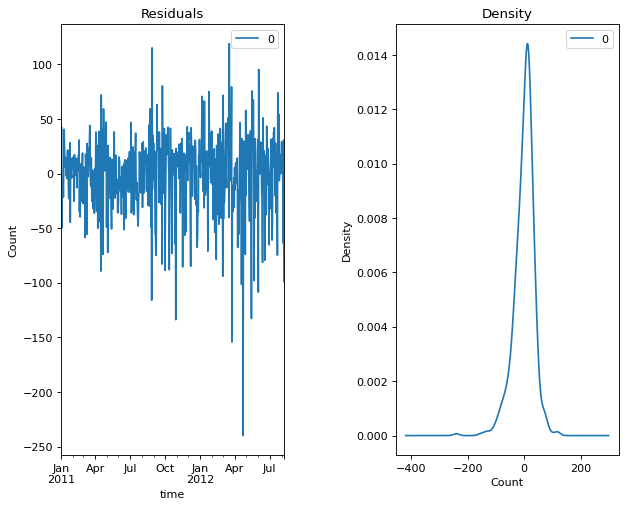

In [80]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig.subplots_adjust(wspace=0.5)
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Count')
plt.show()

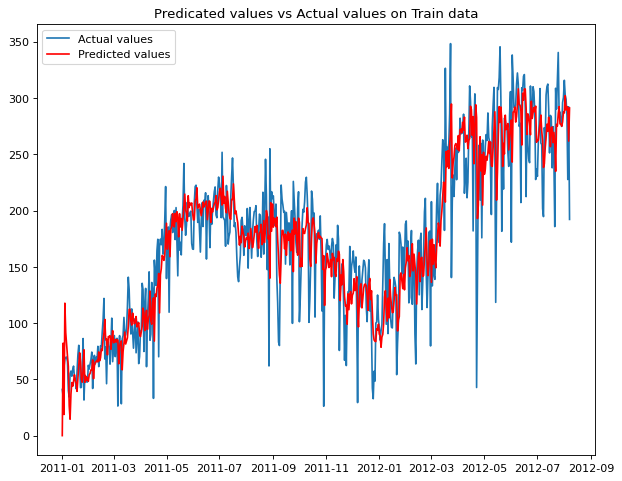

In [85]:
plt.plot(new_train_data['cnt'], label='Actual values')
plt.plot(model_fit.fittedvalues, color='red', label='Predicted values')
plt.title('Predicated values vs Actual values on Train data')
plt.legend()

In [86]:
rmse = np.sqrt(mean_squared_error(new_train_data['cnt'], model_fit.fittedvalues))
mae = mean_absolute_error(new_train_data['cnt'], model_fit.fittedvalues)

print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  35.706282490417294
MAE:  26.021719766603383


In [87]:
steps = len(new_test_data.index)

In [88]:
start = len(new_train_data)
end = len(new_train_data) + len(new_test_data) - 1
result = model_fit.predict(start=start, end=end, type='levels')
result

2012-08-08    251.824074
2012-08-09    268.292078
2012-08-10    273.587303
2012-08-11    274.786379
2012-08-12    275.762215
                 ...    
2012-12-28     95.411655
2012-12-29     92.656548
2012-12-30     92.683278
2012-12-31     89.951534
2013-01-01     85.529489
Freq: D, Name: predicted_mean, Length: 147, dtype: float64

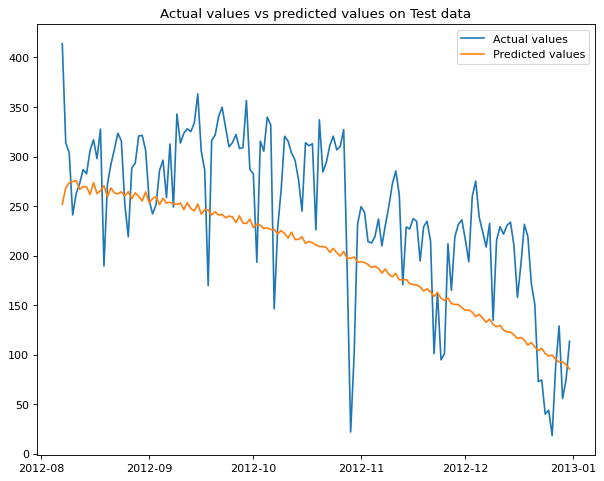

In [90]:


# fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

test = new_test_data[:steps]

plt.plot(test.index, test['cnt'], label='Actual values')
plt.plot(test.index, result, label='Predicted values')
plt.title('Actual values vs predicted values on Test data')
plt.legend()
plt.show()
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(new_train_data, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [91]:
print("For Test Data: ")

testing = new_test_data['cnt']

rmse = np.sqrt(mean_squared_error(testing[:steps], result))
mae = mean_absolute_error(testing[:steps], result)

print("RMSE: ", rmse)
print("MAE: ", mae)

For Test Data: 
RMSE:  72.22144145641559
MAE:  63.04547271058403


# PMDARIMA

In [92]:
train = data.copy()

Text(0, 0.5, 'Count')

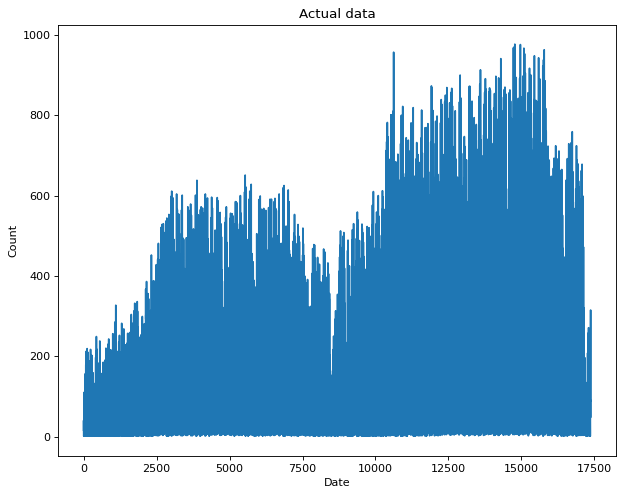

In [93]:
plt.plot(train['cnt'])
plt.title('Actual data')
plt.xlabel('Date')
plt.ylabel("Count")

In [94]:
train.set_index('time', inplace=True)
train.index = pd.to_datetime(train.index)

In [95]:
train = train[['cnt']]

In [96]:
print("Length before resampling: " + str(len(train)))
train = train.resample('D').median()
print("Length after resampling: " + str(len(train)))

Length before resampling: 17379
Length after resampling: 731


Text(0, 0.5, 'Count')

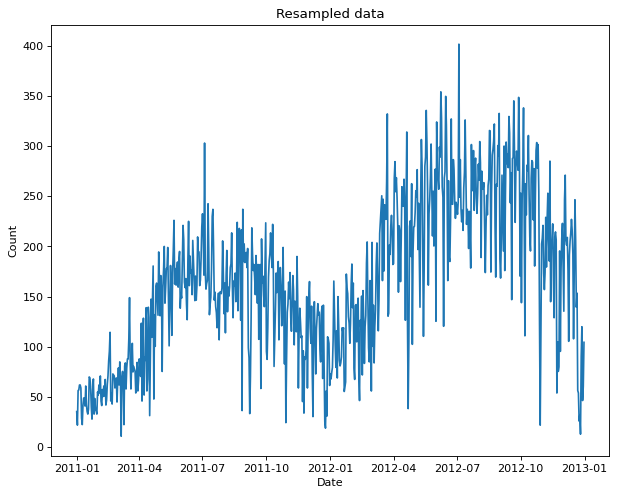

In [98]:
plt.plot(train['cnt'])
plt.title('Resampled data')
plt.xlabel('Date')
plt.ylabel('Count')

In [99]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    result = adfuller(dataset, autolag = 'AIC')
    print('1. ADF: ', result[0])
    print('2. P-Value: ', result[1])
    print('3. Num of lags: ', result[2])
    print('4. Num of observations for ADF regression and critical values calculation: ', result[3])
    print('5. Critical values: ')
    for key, val in result[4].items():
        print('\t', key,":",val)

In [100]:
total = len(train)

split = int(total * 0.75)

new_train = train[:split]
new_test = train[split:]

In [101]:
adf_test(new_train['cnt'])

1. ADF:  -1.3388693688093154
2. P-Value:  0.6112073403795384
3. Num of lags:  13
4. Num of observations for ADF regression and critical values calculation:  534
5. Critical values: 
	 1% : -3.4426552678216003
	 5% : -2.8669676577777548
	 10% : -2.569660749624767


In [102]:
from pmdarima import auto_arima

In [103]:
model = auto_arima(new_train['cnt'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5619.456, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5833.889, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5769.729, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5644.580, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5831.919, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5622.007, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5621.051, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5624.273, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5618.883, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5621.257, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5600.647, Time=0.79 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5618.539, Time=0.76 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=5615.475, Time=0.86 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=5617.373, Time=0.84 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

In [104]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  548
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2792.800
Date:                Thu, 20 Apr 2023   AIC                           5599.601
Time:                        15:38:04   BIC                           5629.732
Sample:                    01-01-2011   HQIC                          5611.379
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4470      0.047     30.582      0.000       1.354       1.540
ar.L2         -1.2199      0.056    -21.836      0.000      -1.329      -1.110
ar.L3          0.1791      0.042      4.274      0.000       0.097       0.261
ma.L1         -2.1462      0.039    -55.711      0.000      -2.222      -2.071
ma.L2          2.0769      0.060     34.682      0.000       1.960       2.194
ma.L3         -0.8468      0.036    -23.834      0.000      -0.916      -0.777
sigma2      1547.9413     73.675     21.010      0.000    1403.541    1692.341
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                98.23
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
model = ARIMA(new_train['cnt'],order=(3,1,3))
model = model.fit()
model.summary()

c:\Users\Akash M\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cnt   No. Observations:                  548
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2792.800
Date:                Thu, 20 Apr 2023   AIC                           5599.601
Time:                        15:38:22   BIC                           5629.732
Sample:                    01-01-2011   HQIC                          5611.379
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4470      0.047     30.582      0.000       1.354       1.540
ar.L2         -1.2199      0.056    -21.836      0.000      -1.329      -1.110
ar.L3          0.1791      0.042      4.274      0.000       0.097       0.261
ma.L1         -2.1462      0.039    -55.711      0.000      -2.222      -2.071
ma.L2          2.0769      0.060     34.682      0.000       1.960       2.194
ma.L3         -0.8468      0.036    -23.834      0.000      -0.916      -0.777
sigma2      1547.9413     73.675     21.010      0.000    1403.541    1692.341
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                98.23
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

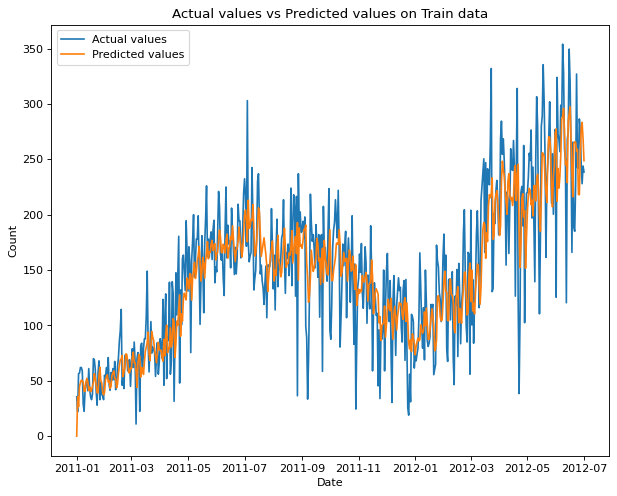

In [110]:
# new_train.plot()
# model.fittedvalues().plot()
plt.plot(new_train['cnt'], label='Actual values')
plt.plot(model.fittedvalues, label='Predicted values')
plt.title('Actual values vs Predicted values on Train data')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

In [108]:
print("For Train Data: ")

testing = new_train['cnt']
result = model.fittedvalues

rmse = np.sqrt(mean_squared_error(testing, result))
mae = mean_absolute_error(testing, result)

print("RMSE: ", rmse)
print("MAE: ", mae)

For Train Data: 
RMSE:  39.818275434663065
MAE:  29.99359075319813


In [109]:
start = len(new_train)
# start = 0
end = len(new_train) + len(new_test) - 1
# end= len(new_test)
pred = model.predict(start=start, end = end, type='levels')

pred

2012-07-02    225.634333
2012-07-03    216.191998
2012-07-04    225.931108
2012-07-05    249.238669
2012-07-06    269.392061
                 ...    
2012-12-27    239.315524
2012-12-28    232.536616
2012-12-29    235.039873
2012-12-30    244.928939
2012-12-31    254.970453
Freq: D, Name: predicted_mean, Length: 183, dtype: float64

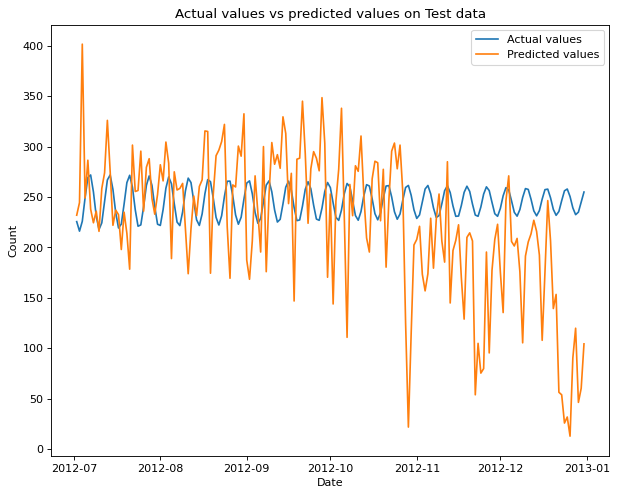

In [112]:
# pred.plot(legend=True)
# new_test['cnt'].plot(legend=True)
plt.plot(pred, label='Actual values')
plt.plot(new_test['cnt'], label='Predicted values')
plt.title("Actual values vs predicted values on Test data")
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

In [113]:
# from the above graph we can say that ARIMA was able to capture the trend approximately.
# Due to lower amount of train data it is not able to predict precisely

print("For Test Data: ")

testing = new_test['cnt']
result = pred

rmse = np.sqrt(mean_squared_error(testing, result))
mae = mean_absolute_error(testing, result)

print("RMSE: ", rmse)
print("MAE: ", mae)

For Test Data: 
RMSE:  78.70560083486802
MAE:  59.68783306500656


# SARIMA

In [114]:
from pmdarima.arima import auto_arima

# Split data into training and testing sets

copy = data.copy()


copy.set_index('time', inplace=True)
copy.index = pd.to_datetime(copy.index)
copy = copy[['cnt']]
copy = copy.resample('D').median()

split = int(len(copy) * 0.75)
train = copy[:split]
test = copy[split:]

print('Train Length: ', len(train))
print("Test Length: ", len(test))

Train Length:  548
Test Length:  183


In [115]:
# Fit the best SARIMA model using auto_arima
model = auto_arima(train['cnt'], seasonal=True, m=12, stepwise=True, suppress_warnings=True, start_p=1, start_q=1, test='adf', max_p=20, max_q=20)

# Generate forecasts for the test set
forecast = model.predict(n_periods=len(test))

# Print the model summary
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  548
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood               -2799.857
Date:                             Thu, 20 Apr 2023   AIC                           5617.714
Time:                                     15:41:23   BIC                           5656.454
Sample:                                 01-01-2011   HQIC                          5632.857
                                      - 07-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5168      0.344      1.501      0.133      -0.158       1.192
ar.L1          0.1481      

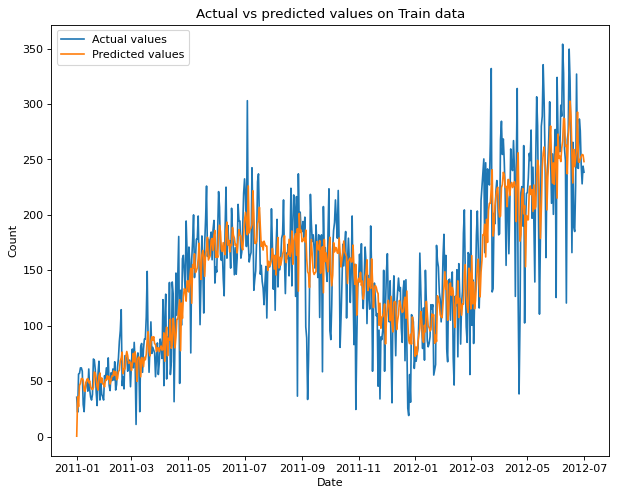

In [116]:
plt.plot(train.index, train['cnt'], label='Actual values')
plt.plot(train.index, model.fittedvalues(), label='Predicted values')
plt.title('Actual vs predicted values on Train data')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

In [117]:
print("For Train Data: ")

training = train['cnt']
result = model.fittedvalues()

rmse = np.sqrt(mean_squared_error(training, result))
mae = mean_absolute_error(training, result)

print("RMSE: ", rmse)
print("MAE: ", mae)

For Train Data: 
RMSE:  40.37578807781383
MAE:  30.372526125783782


In [118]:
forecast

2012-07-02    258.708741
2012-07-03    265.172438
2012-07-04    261.997467
2012-07-05    250.914828
2012-07-06    256.245197
                 ...    
2012-12-27    321.991285
2012-12-28    322.374774
2012-12-29    322.758264
2012-12-30    323.141753
2012-12-31    323.525243
Freq: D, Length: 183, dtype: float64

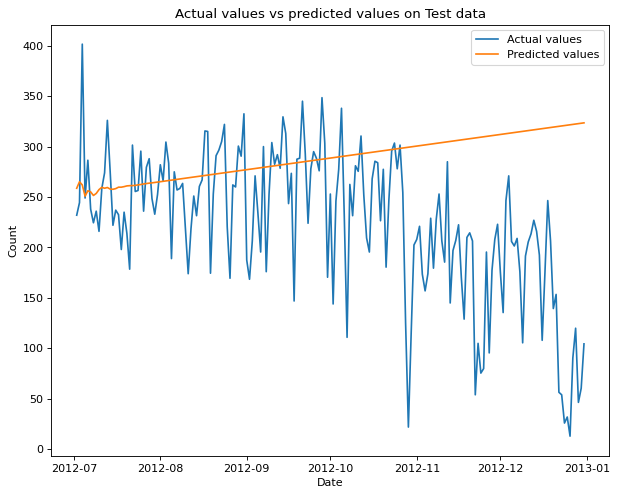

In [119]:
plt.plot(test.index, test.cnt, label='Actual values')
plt.plot(test.index, forecast, label='Predicted values')
plt.title('Actual values vs predicted values on Test data')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

In [120]:
print("For Test Data: ")

testing = test['cnt']
result = forecast

mse = np.sqrt(mean_squared_error(testing, result))
mae = mean_absolute_error(testing, result)

print("RMSE: ", rmse)
print("MAE: ", mae)

For Test Data: 
RMSE:  40.37578807781383
MAE:  77.68819738666555


# LSTM

In [121]:
df = data.copy()
df.tail()

WINDOW_SIZE=24

In [122]:
df.index = pd.to_datetime(df['time'])

In [123]:
# Split the data into three 0.8, 0.1, 0.1 for training, validation and testing

col = df['cnt']

total_length = len(col)

train_ratio, validation_ratio = 0.8, 0.1

train_length = int(train_ratio * total_length)
validation_length = int(validation_ratio * total_length)
test_length = total_length - ( train_length + validation_length )

train_data = col[:train_length]
validation_data = col[train_length:train_length + validation_length]
test_data = col[train_length + validation_length : ]

upper_bound, lower_bound = 1, 0

train_data, _ = replace_outliers_quantile(train_data, lower_bound, upper_bound)
validation_data, _ = replace_outliers_quantile(validation_data, lower_bound, upper_bound)

In [124]:
# Split the data into three 0.8, 0.1, 0.1 for training, validation and testing

col = df['cnt']

total_length = len(col)

train_ratio, validation_ratio = 0.8, 0.1

train_length = int(train_ratio * total_length)
validation_length = int(validation_ratio * total_length)
test_length = total_length - ( train_length + validation_length )

train_data = col[:train_length]
validation_data = col[train_length:train_length + validation_length]
test_data = col[train_length + validation_length : ]

upper_bound, lower_bound = 1, 0

train_data, _ = replace_outliers_quantile(train_data, lower_bound, upper_bound)
validation_data, _ = replace_outliers_quantile(validation_data, lower_bound, upper_bound)

In [125]:
x_train,y_train = matrix_and_vector_generator(train_data, WINDOW_SIZE)
x_validation, y_validation = matrix_and_vector_generator(validation_data, WINDOW_SIZE)
x_test, y_test = matrix_and_vector_generator(test_data, WINDOW_SIZE)

print("Train Shape: ", str(x_train.shape),' - ', str(y_train.shape))
print("Validation Shape: ", str(x_validation.shape),' - ', str(y_validation.shape))
print("Test Shape: ", str(x_test.shape),' - ', str(y_test.shape))

Train Shape:  (13879, 24)  -  (13879,)
Validation Shape:  (1713, 24)  -  (1713,)
Test Shape:  (1715, 24)  -  (1715,)


In [138]:
# length = x.shape[0]

# test_length = int(length * 0.8)
# val_length = int(length * 0.1)

# x_train, y_train = x[:test_length], y[:test_length]
# x_val, y_val  = x[test_length:test_length + val_length], y[test_length:test_length + val_length]
# x_test, y_test = x[test_length + val_length:], y[test_length + val_length:]

In [126]:
model1 = Sequential()

model1.add(InputLayer((WINDOW_SIZE, 1)))

model1.add(LSTM(128))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(24, activation='relu'))
model1.add(Dense(1))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 71,481
Trainable params: 71,481
Non-traina

In [127]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[Mae()])

In [128]:
history = model1.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=10, callbacks=[cp])

Epoch 1/10
431/434 [============================>.] - ETA: 0s - loss: 159.5646 - mean_absolute_error: 159.5646

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 12s 22ms/step - loss: 159.1927 - mean_absolute_error: 159.1927 - val_loss: 232.8303 - val_mean_absolute_error: 232.8303
Epoch 2/10
434/434 [==============================] - ETA: 0s - loss: 73.6300 - mean_absolute_error: 73.6300

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 14s 32ms/step - loss: 73.6300 - mean_absolute_error: 73.6300 - val_loss: 100.6424 - val_mean_absolute_error: 100.6424
Epoch 3/10
434/434 [==============================] - ETA: 0s - loss: 42.5107 - mean_absolute_error: 42.5107

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 14s 33ms/step - loss: 42.5107 - mean_absolute_error: 42.5107 - val_loss: 74.7627 - val_mean_absolute_error: 74.7627
Epoch 4/10
434/434 [==============================] - ETA: 0s - loss: 38.1866 - mean_absolute_error: 38.1866

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 14s 32ms/step - loss: 38.1866 - mean_absolute_error: 38.1866 - val_loss: 64.8674 - val_mean_absolute_error: 64.8674
Epoch 5/10
434/434 [==============================] - ETA: 0s - loss: 36.3528 - mean_absolute_error: 36.3528

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 15s 34ms/step - loss: 36.3528 - mean_absolute_error: 36.3528 - val_loss: 62.2082 - val_mean_absolute_error: 62.2082
Epoch 6/10
434/434 [==============================] - ETA: 0s - loss: 34.8696 - mean_absolute_error: 34.8696

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 15s 34ms/step - loss: 34.8696 - mean_absolute_error: 34.8696 - val_loss: 60.0783 - val_mean_absolute_error: 60.0783
Epoch 7/10
433/434 [============================>.] - ETA: 0s - loss: 33.8801 - mean_absolute_error: 33.8801

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 14s 31ms/step - loss: 33.8647 - mean_absolute_error: 33.8647 - val_loss: 56.7318 - val_mean_absolute_error: 56.7318
Epoch 8/10
432/434 [============================>.] - ETA: 0s - loss: 32.5638 - mean_absolute_error: 32.5638

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 13s 30ms/step - loss: 32.5852 - mean_absolute_error: 32.5852 - val_loss: 54.2241 - val_mean_absolute_error: 54.2241
Epoch 9/10
434/434 [==============================] - 10s 22ms/step - loss: 31.8159 - mean_absolute_error: 31.8159 - val_loss: 54.4200 - val_mean_absolute_error: 54.4200
Epoch 10/10
432/434 [============================>.] - ETA: 0s - loss: 30.7238 - mean_absolute_error: 30.7238

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 15s 35ms/step - loss: 30.7262 - mean_absolute_error: 30.7262 - val_loss: 52.0424 - val_mean_absolute_error: 52.0424


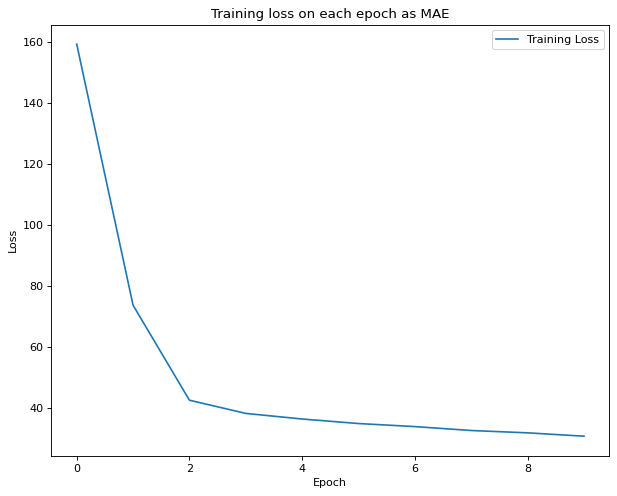

In [129]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training loss on each epoch as MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [167]:
from keras.models import load_model

model1 = load_model('model1/')

In [168]:
train_predictions = model1.predict(x_train).flatten()

434/434 [==============================] - 3s 5ms/step


In [169]:
train_predictions.shape, y_train.shape

((13879,), (13879,))

In [170]:
train_results = pd.DataFrame(data={'Train predictions': train_predictions, 'Actuals' : y_train} )

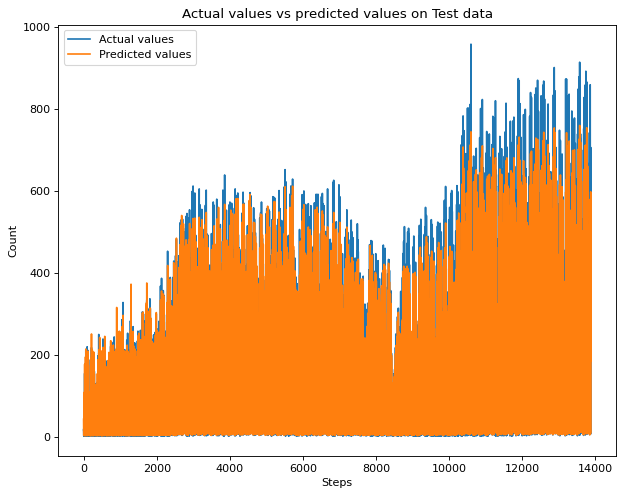

In [171]:
size = None

predictions = None
actuals = None

if size != None:
    predictions = train_results['Train predictions'][:size]
    actuals = train_results['Actuals'][:size]
else:
    predictions = train_results['Train predictions'][:]
    actuals = train_results['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values on Test data')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [172]:
from sklearn.metrics import mean_squared_error, median_absolute_error

actuals = train_results['Actuals']
predicted = train_results['Train predictions']

print("For Train data:")

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

For Train data:
MAE:  29.98777995365344
RMSE: 51.00897385182138


In [173]:
test_predictions = model1.predict(x_test).flatten()

54/54 [==============================] - 0s 5ms/step


In [174]:
test_predictions.shape, y_test.shape

((1715,), (1715,))

In [175]:
test_results = pd.DataFrame(data={'Test predictions': test_predictions, 'Actuals' : y_test} )

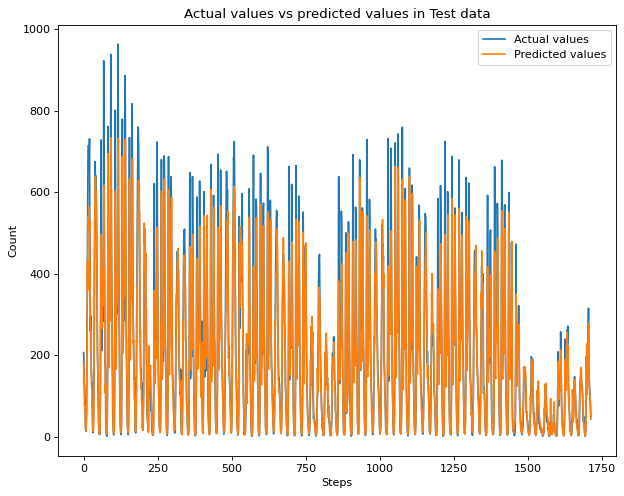

In [176]:
size = None

predictions = None
actuals = None

x = test_results

if size != None:
    predictions = x['Test predictions'][:size]
    actuals = x['Actuals'][:size]
else:
    predictions = x['Test predictions'][:]
    actuals = x['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values in Test data')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [177]:
actuals = test_results['Actuals']
predicted = test_results['Test predictions']

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

# calculate MSE
rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

MAE:  35.67287590684418
RMSE: 59.29284863893146


# GRU

In [141]:
df = data.copy()
df.index = pd.to_datetime(df['time'])
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
time,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,01-01-2011 00:00:00
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,01-01-2011 01:00:00
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,01-01-2011 02:00:00
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,01-01-2011 03:00:00
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,01-01-2011 04:00:00


In [142]:
# Split the data into three 0.8, 0.1, 0.1 for training, validation and testing

col = df['cnt']

total_length = len(col)

train_ratio, validation_ratio = 0.8, 0.1

train_length = int(train_ratio * total_length)
validation_length = int(validation_ratio * total_length)
test_length = total_length - ( train_length + validation_length )

train_data = col[:train_length]
validation_data = col[train_length:train_length + validation_length]
test_data = col[train_length + validation_length : ]

upper_bound, lower_bound = 1, 0

train_data, _ = replace_outliers_quantile(train_data, lower_bound, upper_bound)
validation_data, _ = replace_outliers_quantile(validation_data, lower_bound, upper_bound)

In [143]:
WINDOW_SIZE = 24

x_train,y_train = matrix_and_vector_generator(train_data, WINDOW_SIZE)
x_validation, y_validation = matrix_and_vector_generator(validation_data, WINDOW_SIZE)
x_test, y_test = matrix_and_vector_generator(test_data, WINDOW_SIZE)

print("Train Shape: ", str(x_train.shape),' - ', str(y_train.shape))
print("Validation Shape: ", str(x_validation.shape),' - ', str(y_validation.shape))
print("Test Shape: ", str(x_test.shape),' - ', str(y_test.shape))

Train Shape:  (13879, 24)  -  (13879,)
Validation Shape:  (1713, 24)  -  (1713,)
Test Shape:  (1715, 24)  -  (1715,)


In [144]:
model2 = Sequential()

model2.add(InputLayer((WINDOW_SIZE, 1)))

model2.add(GRU(64, activation='relu'))
model2.add(Dense(48, activation='relu'))
model2.add(Dense(48, activation='relu'))
model2.add(Dense(48, activation='relu'))
model2.add(Dense(48, activation='relu'))

model2.add(Dense(1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_5 (Dense)             (None, 48)                3120      
                                                                 
 dense_6 (Dense)             (None, 48)                2352      
                                                                 
 dense_7 (Dense)             (None, 48)                2352      
                                                                 
 dense_8 (Dense)             (None, 48)                2352      
                                                                 
 dense_9 (Dense)             (None, 1)                 49        
                                                                 
Total params: 23,089
Trainable params: 23,089
Non-trai

In [145]:
cp = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[Mae()])

In [146]:
history = model2.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=10, callbacks=[cp])

Epoch 1/10
429/434 [============================>.] - ETA: 0s - loss: 75.7650 - mean_absolute_error: 75.7650INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 7s 13ms/step - loss: 75.4516 - mean_absolute_error: 75.4516 - val_loss: 65.6311 - val_mean_absolute_error: 65.6311
Epoch 2/10
433/434 [============================>.] - ETA: 0s - loss: 39.8218 - mean_absolute_error: 39.8218INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 6s 13ms/step - loss: 39.8435 - mean_absolute_error: 39.8435 - val_loss: 56.1562 - val_mean_absolute_error: 56.1562
Epoch 3/10
434/434 [==============================] - ETA: 0s - loss: 36.8076 - mean_absolute_error: 36.8076INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 6s 15ms/step - loss: 36.8076 - mean_absolute_error: 36.8076 - val_loss: 52.6985 - val_mean_absolute_error: 52.6985
Epoch 4/10
433/434 [============================>.] - ETA: 0s - loss: 34.9281 - mean_absolute_error: 34.9281INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 6s 13ms/step - loss: 34.9340 - mean_absolute_error: 34.9340 - val_loss: 51.0544 - val_mean_absolute_error: 51.0544
Epoch 5/10
433/434 [============================>.] - ETA: 0s - loss: 33.3137 - mean_absolute_error: 33.3137INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 7s 16ms/step - loss: 33.3084 - mean_absolute_error: 33.3084 - val_loss: 47.5709 - val_mean_absolute_error: 47.5709
Epoch 6/10
433/434 [============================>.] - ETA: 0s - loss: 32.1513 - mean_absolute_error: 32.1513INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 7s 16ms/step - loss: 32.1531 - mean_absolute_error: 32.1531 - val_loss: 45.7510 - val_mean_absolute_error: 45.7510
Epoch 7/10
434/434 [==============================] - 4s 9ms/step - loss: 30.6702 - mean_absolute_error: 30.6702 - val_loss: 46.4811 - val_mean_absolute_error: 46.4811
Epoch 8/10
430/434 [============================>.] - ETA: 0s - loss: 30.4005 - mean_absolute_error: 30.4005INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 6s 15ms/step - loss: 30.3962 - mean_absolute_error: 30.3962 - val_loss: 44.2248 - val_mean_absolute_error: 44.2248
Epoch 9/10
434/434 [==============================] - ETA: 0s - loss: 29.4464 - mean_absolute_error: 29.4464INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


434/434 [==============================] - 5s 12ms/step - loss: 29.4464 - mean_absolute_error: 29.4464 - val_loss: 41.8218 - val_mean_absolute_error: 41.8218
Epoch 10/10
434/434 [==============================] - 4s 10ms/step - loss: 28.7227 - mean_absolute_error: 28.7227 - val_loss: 41.9742 - val_mean_absolute_error: 41.9742


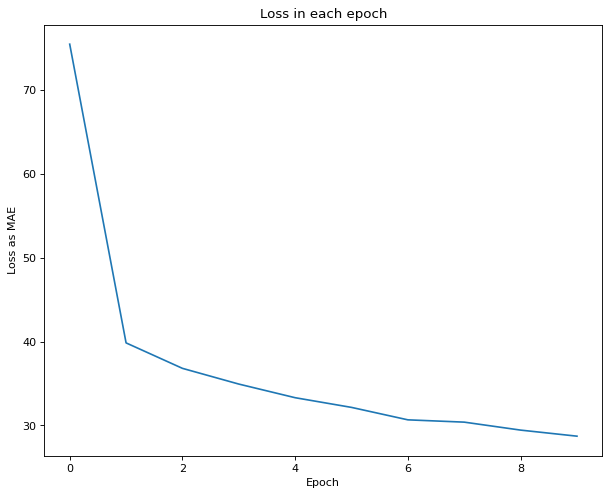

In [147]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss as MAE')
plt.title("Loss in each epoch")
plt.show()

In [148]:
from keras.models import load_model

model2 = load_model('model2/')

In [149]:
train_predictions = model2.predict(x_train).flatten()

434/434 [==============================] - 1s 2ms/step


In [150]:
train_predictions.shape, y_train.shape

((13879,), (13879,))

In [151]:
train_results = pd.DataFrame(data={'Train predictions': train_predictions, 'Actuals' : y_train} )

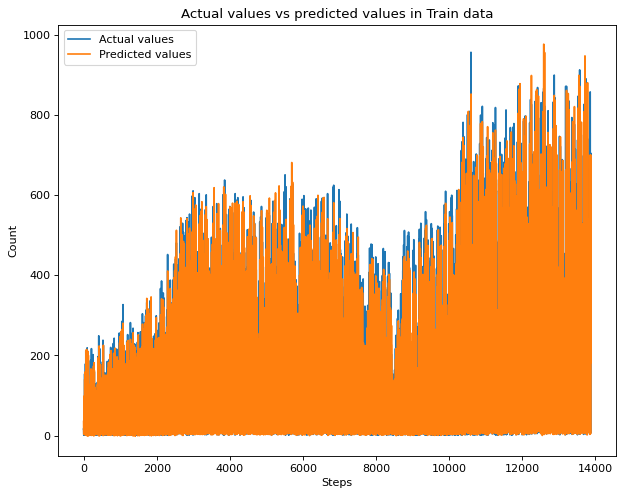

In [152]:
size = None

predictions = None
actuals = None

if size != None:
    predictions = train_results['Train predictions'][:size]
    actuals = train_results['Actuals'][:size]
else:
    predictions = train_results['Train predictions'][:]
    actuals = train_results['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values in Train data')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [160]:
from sklearn.metrics import mean_squared_error, median_absolute_error

actuals = train_results['Actuals']
predicted = train_results['Train predictions']

print("For Train data:")

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

For Train data:
MAE:  28.648869202054822
RMSE: 48.451681879677444


In [162]:
test_predictions = model2.predict(x_test).flatten()

54/54 [==============================] - 0s 3ms/step


In [163]:
test_predictions.shape, y_test.shape

((1715,), (1715,))

In [164]:
test_results = pd.DataFrame(data={'Test predictions': test_predictions, 'Actuals' : y_test} )

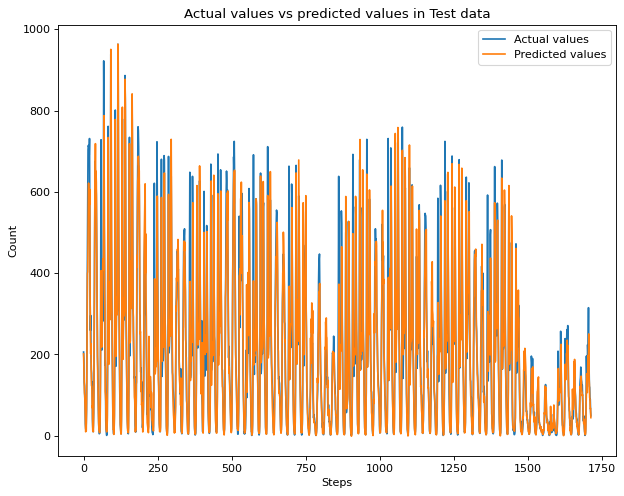

In [165]:
size = None

predictions = None
actuals = None

x = test_results

if size != None:
    predictions = x['Test predictions'][:size]
    actuals = x['Actuals'][:size]
else:
    predictions = x['Test predictions'][:]
    actuals = x['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values in Test data')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [166]:
actuals = test_results['Actuals']
predicted = test_results['Test predictions']

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

# calculate MSE
rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

MAE:  33.33067562103098
RMSE: 58.38461345486867
